In [6]:
%pwd
from theano.sandbox import cuda
cuda.use('gpu0')
%matplotlib inline

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.


In [7]:
import os
base= os.getcwd() + "/data/redux"
base= os.getcwd() + "/data/redux/sample"
train= base+"/train"
test= base+"/test"
valid= base+"/valid"
results_path = base+"/results"


In [8]:
from matplotlib import pyplot as plt
import bcolz
def plot(img):
    plt.imshow(img)
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

In [9]:

    
import json   
import keras.preprocessing.image as preprocess
from keras.models import Sequential
import numpy as np
from keras.layers.core import Lambda, Flatten, Dropout, Dense
from keras.layers.convolutional import ZeroPadding2D, Convolution2D, MaxPooling2D
from keras.utils.data_utils import get_file
from keras.optimizers import Adam


vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
def vgg_preprocess(x):
    """
        Subtracts the mean RGB value, and transposes RGB to BGR.
        The mean RGB was computed on the image set used to train the VGG model.

        Args: 
            x: Image array (height x width x channels)
        Returns:
            Image array (height x width x transposed_channels)
    """
    x = x - vgg_mean
#     print x
#     import pdb;pdb.set_trace()
    return x[:, ::-1] # reverse axis rgb->bgr

class hgg:
    def get_classes(self):
        fname = 'imagenet_class_index.json'
        fpath = get_file(fname, self.FILE_PATH+fname, cache_subdir='models')
        with open(fpath) as f:
            class_dict = json.load(f)
        self.classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

    def get_batches(self,path, shuffle=True, batch_size=8, rotation_range=10 ,width_shift_range=10, height_shift_range=10, shear_range=0.3, class_mode='categorical' ):
#         imageGenerator doc at https://keras.io/preprocessing/image/
        imageGenerator = preprocess.ImageDataGenerator(
#             rotation_range=rotation_range,
#             width_shift_range=width_shift_range,
#             height_shift_range=height_shift_range,
#             shear_range=shear_range,
#             zoom_range=0
        )
        return imageGenerator.flow_from_directory(
            shuffle=shuffle,
            directory=path, 
            target_size=(224,224),
            batch_size=batch_size,
            class_mode=class_mode
        )
    def __init__(self):
        self.FILE_PATH = 'http://files.fast.ai/models/'

        self.createModel()
        self.get_classes()
        pass
    def createModel(self,):
        # Sequential doc at https://keras.io/getting-started/sequential-model-guide/
        self.model=Sequential()
        self.model.add(Lambda(vgg_preprocess, input_shape=(3,224,224), output_shape=(3,224,224)))
        self.addConvLayer(2,64)
        self.addConvLayer(2,128)
        self.addConvLayer(3,256)
        self.addConvLayer(3,512)
        self.addConvLayer(3,512)
        
        self.model.add(Flatten())
        
        self.model.add(Dense(4096,activation='relu'))
        self.model.add(Dropout(0.5))
        
        self.model.add(Dense(4096,activation='relu'))
        self.model.add(Dropout(0.5))
        
        
        self.model.add(Dense(1000,activation='softmax'))
        
        
        fname="vgg16.h5"
        self.model.load_weights(get_file(fname, self.FILE_PATH+fname, cache_subdir='models'))
        
    def addConvLayer(self,layers,filters):
        # Convolution2D https://keras.io/layers/convolutional/
        for i in range(layers):
            self.model.add(ZeroPadding2D((1,1)))
            self.model.add(Convolution2D(filters,3,3,activation='relu'))
        self.model.add(MaxPooling2D((2,2),strides=(2,2)))
        
    def ModifyLastLayerToNewOutput(self, no_of_outputs):
        self.model.pop()
        for layer in self.model.layers: layer.trainable=False
        self.model.add(Dense(no_of_outputs,activation='softmax'))
        print no_of_outputs
        self.compile()
    def finetune(self,batches):
        self.ModifyLastLayerToNewOutput(batches.nb_class)
        classes = list(iter(batches.class_indices)) # get a list of all the class labels
        
        # batches.class_indices is a dict with the class name as key and an index as value
        # eg. {'cats': 0, 'dogs': 1}

        # sort the class labels by index according to batches.class_indices and update model.classes
        for c in batches.class_indices:
            classes[batches.class_indices[c]] = c
        self.classes = classes
        
        
    def compile(self, lr=0.001):
        self.model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy',metrics=['accuracy'])
    def fit(self,train_batches, validation_batches):
        self.model.fit_generator(train_batches, 
                        samples_per_epoch = train_batches.nb_sample,
                        nb_epoch=1, 
                        validation_data = validation_batches,
                        nb_val_samples = validation_batches.nb_sample,
                       )
   
h = hgg()
# from vgg16 import Vgg16

# h=Vgg16()

In [10]:
batch_size=8
train_batches = h.get_batches(train, batch_size=batch_size)
validation_batches = h.get_batches(valid, batch_size=batch_size)
test_batches = h.get_batches(test, batch_size=batch_size)
# validation_batches
# plot(validation_batches)


Found 200 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 3 images belonging to 1 classes.


In [11]:
h.finetune(train_batches)

2


In [13]:
train_now=False

no_of_epochs=3
if train_now==True:
    latest_weights_filename = None
    for epoch in range(no_of_epochs):
        print "Running epoch: %d" % epoch
        if(epoch>=2):
            h.model.optimizer.lr = 0.001
        h.fit(train_batches, validation_batches)
        latest_weights_filename = '/ft%d.h5' % epoch
        h.model.save_weights(results_path+latest_weights_filename)
    print "Completed %s fit operations" % no_of_epochs
else:
    print "loading from saved_model"
    h.model.load_weights(results_path+"/vgg/ft2.h5")
    


loading from saved_model


In [42]:
# validation_batches = h.get_batches(valid, batch_size=batch_size, shuffle=False, class_mode=None)
validation_batches = h.get_batches(valid, batch_size=batch_size, shuffle=False)

preds=h.model.predict_generator(validation_batches, validation_batches.nb_sample)

Found 50 images belonging to 2 classes.


In [43]:
is_dog = np.round(1- preds)
print is_dog[:5]
filenames = validation_batches.filenames
print filenames[:5]
print len(preds)

[[ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]]
['cats/cat.10369.jpg', 'cats/cat.10396.jpg', 'cats/cat.10579.jpg', 'cats/cat.12469.jpg', 'cats/cat.12499.jpg']
50


In [44]:
with open("submit.txt","a") as f:
    f.write("id,label\n")
    for i in range(len(preds)):
        if(is_dog[i][0]==1):
            is_dog[i][0]=0.05
        else:
            is_dog[i][0]=0.95
        print filenames[i][8:-4],",",is_dog[i][0]
        f.write("%s,%s\n"%(str(filenames[i][8:-4]),str(is_dog[i][0])) )

.10369 , 0.95
.10396 , 0.95
.10579 , 0.95
.12469 , 0.95
.12499 , 0.05
.2450 , 0.95
.3298 , 0.95
.3363 , 0.95
.3537 , 0.95
.3765 , 0.95
.4895 , 0.95
.7474 , 0.95
.7866 , 0.95
.811 , 0.95
.8324 , 0.95
.8483 , 0.95
.8705 , 0.95
.9557 , 0.95
.9889 , 0.95
.10007 , 0.05
.10146 , 0.05
.10167 , 0.05
.1117 , 0.05
.1169 , 0.05
.12177 , 0.05
.1466 , 0.05
.1550 , 0.05
.1902 , 0.05
.2051 , 0.05
.2327 , 0.05
.2470 , 0.05
.2569 , 0.05
.2652 , 0.05
.3022 , 0.05
.3295 , 0.05
.3575 , 0.05
.3918 , 0.05
.5966 , 0.05
.6184 , 0.05
.6260 , 0.05
.6599 , 0.05
.6650 , 0.05
.7906 , 0.05
.81 , 0.05
.8655 , 0.05
.9110 , 0.05
.9422 , 0.05
.9606 , 0.05
.9627 , 0.05
.9640 , 0.05


In [45]:
from PIL import Image
import random
isdog = preds[:,1]
isdog = isdog.clip(min=0.05, max=0.95)



36
[  7.56838825e-04   9.99243140e-01]
0.95
dogs/dog.3918.jpg
50


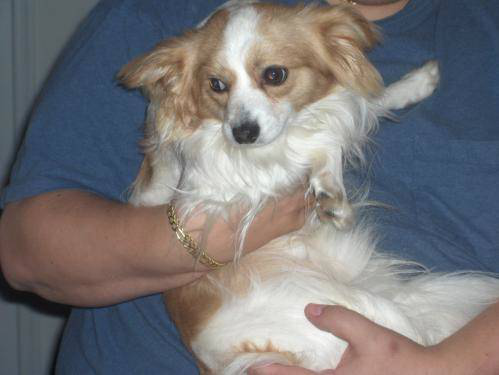

In [46]:
idx=int(random.random()*len(preds))
print idx
print preds[idx]
print isdog[idx]
print filenames[idx]
print len(preds)

Image.open(valid+"/" + filenames[idx])

[[18  1]
 [ 0 31]]


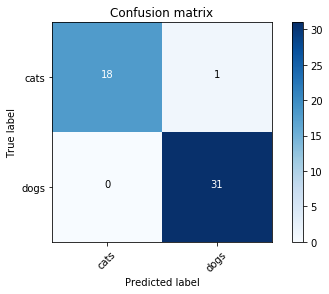

In [47]:
import itertools
from numpy.random import random, permutation
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(valid + "/" +filenames[i]) for i in idx], titles=titles)
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')


#Number of images to view for each visualization task
n_view = 4
from sklearn.metrics import confusion_matrix
expected_labels = validation_batches.classes #0 or 1

#Round our predictions to 0/1 to generate labels
our_predictions = preds[:,0]
our_labels = np.round(1-our_predictions)

cm = confusion_matrix(expected_labels, our_labels)
plot_confusion_matrix(cm, validation_batches.class_indices)

In [48]:
save_array(results_path + '/test_preds.dat', preds)
save_array(results_path + '/filenames.dat', filenames)

Found 1 correct labels
[4]


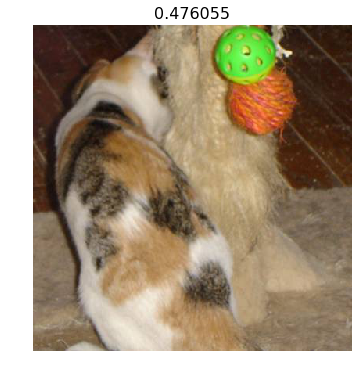

In [49]:
#1. A few correct labels at random
correct = np.where(our_labels!=expected_labels)[0]
print "Found %d correct labels" % len(correct)
idx = permutation(correct)[:n_view]
print idx
plots_idx(idx, our_predictions[idx])